# Street-Based Demographics
## Why block-level aggregations fail to capture urban demographic patterns

## Introduction

We live in a world where emerging, "big" data sources are increasingly informing our understanding of society. Things like social media, geolocated phone logs, and satellite imagery are beginning to provide glimpses into how urban areas function. Even so, official federal statistical programs are still the bedrock of demographic research in the United States. The Decennial Census and American Community Survey inform the allocation of roughly [\$675B in federal aid](https://www.census.gov/library/working-papers/2017/decennial/census-data-federal-funds.html), and generate around [17,000 academic publications each year](http://users.hist.umn.edu/~ruggles/Articles/Privacy).

These statistical programs only release aggregated data, since they are legally required to protect the privacy of the American public. To do so, households are grouped by blocks -- essentially a polygon bounded by three or more streets (or by streets and another administrative boundary such as a county line). Grouping people by blocks is simple, consistent, and straight-forward. Block polygons easily nest into larger administrative units, and are primarily bounded by recognizable physical features. Despite their simplicity, block-level groupings aren't necessarily the best way of capturing spatial patterns.

This notebook explores the degree to which block-level aggregations are appropriate for capturing real spatial patterns in socioeconomic characteristics.

### The importance of streets

As residential streets are where social interactions occur, there is reason to believe that demographic characteristics tend to follow a street network. For example, Jane Jacob's [seminal description of urban neighborhoods](https://en.wikipedia.org/wiki/The_Death_and_Life_of_Great_American_Cities) emphasizes the importance of streets in determining the safety, vibrancy, and character of a neighborhood. Empirically, [Rick Grannis](https://www.jstor.org/stable/10.1086/231400) finds that racial patterns in Californian urban neighborhoods are strongly predicted by a connected network of small, residential streets. If two neighborhoods are connected by such streets, even if they are several neighborhoods removed, they are more likely to have similar racial compositions than neighborhoods immediately next to each other but that are not connected by such streets.


Despite mounting empirical evidence of the importance of road networks, the Census's current system splits streets down the middle. Data from a household are grouped together with another household on the other end of the block, but are not grouped with the neighbors directly across the street (who are frequently closer). Given the goal of producing sociologically meaningful and policy-relevant information, this technique might mean the Census isn't aggregating households as well as they could be.

In this project, I determine the extent to which street-aggregated demographic data differs from the current block system. To do so, I test whether there is street-level clustering of demographic characteristics within blocks. If streets are unimportant, knowing which side of a block an individual lives on does not let me predict their demographic traits any better than knowing the block-level averages. If people organize themselves by street, however, block-level aggregations might fail to capture demographic patterns ocurring at a small scale.

## Looking within blocks

Because blocks are the highest-resolution Census data available to the public, it is not possible to use public data to explore patterns that occur at a different scale or shape than block boundaries.

Fortunately, I have had access to Census microdata within a [secure facility](https://www.colorado.edu/rocky-mountain-research-data-center/). In this data center, I am able to access an extract of the Master Address File. This is a huge database containing physical addresses for virtually every household (occupied or vacant) in the country. The Census works closely with the US Postal Service, as well as local governments, to update and maintain this database. When official surveys are administered, this giant list of addresses is the sampling frame.

Each of these address points have a unique identifier. The majority -- roughly three-quarters -- of them also have latitude and longitude coordinates. Using this ID, I am able to link coordinates of households with coded responses to the 2000 Decennial Census. This gives me something close to point-level demographic data for most households in the nation. Point-level data lets me start from scratch, and explore the effects of aggregating data in novel ways.

The variables I extracted from the 2000 Decennial Census responses include individual characteristics -- such as race and age -- as well as household characteristics -- such as household/family structure, family size, presence of elderly and children, and whether an address is owned, rented, or vacant.

For this exploration, I chose to limit my study to eight counties: Los Angeles, Denver, Cook, Bronx, Kings, Queens, New York, and Harris. These counties roughly correspond with the cities of Los Angeles, Denver, Chicago, New York, and Houston. I chose these cities to represent major urban areas in different regions of the US, as is evident in the map below. Denver is notably smaller than the other cities, but is a city with which I have personal familiarity. Such familiarity proved helpful when checking the reliability of my code, and when beginning to interpret my results.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import cenpy as cen
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from map_tracts import get_vacant_rates, plot_vacant, hist_vacant

%matplotlib inline

In [2]:
m = folium.Map(
    location=[40, -95],
    zoom_start=4,
    tiles='cartodbpositron'
)

tooltip = 'Click me!'

folium.Marker([34.052235, -118.243683], popup='<b>Los Angeles</b>', tooltip=tooltip).add_to(m)
folium.Marker([39.742043, -104.991531], popup='<b>Denver</b>', tooltip=tooltip).add_to(m)
folium.Marker([41.881832, -87.623177], popup='<b>Cook</b>', tooltip=tooltip).add_to(m)
folium.Marker([40.837048, -73.865433], popup='<b>Bronx</b>', tooltip=tooltip).add_to(m)
folium.Marker([40.650002, -73.949997], popup='<b>Kings</b>', tooltip=tooltip).add_to(m)
folium.Marker([40.742054, -73.769417], popup='<b>Queens</b>', tooltip=tooltip).add_to(m)
folium.Marker([40.758896, -73.985130], popup='<b>New York</b>', tooltip=tooltip).add_to(m)
folium.Marker([29.749907, -95.358421], popup='<b>Harris</b>', tooltip=tooltip).add_to(m)

m

### Matching addresses to street segments: (Almost) Geoless Geocoding

In order to aggregate point-level demographic data by streets, I first needed to link each address point to a segment of the street network. The Census maintains an official map of streets, as well as other physical features. These are called [Topologically Integrated Geographic Encoding and Referencing (TIGER) files](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html). One such file includes the geography and attributes for all of the streets and other linear features (streams, railroads, county lines, pedestrian paths, on-ramps, ditches, etc.) in the country.

Streets are further divided into segments -- chunks of road network divided by intersections with other streets. Each of these short pieces of road have IDs, and a street name.

The most time-consuming portion of this project involved linking each address point to one of these street segments. This preprocessing is not the primary focus of this notebook. If you would like to learn more about how this was accomplished -- a task that did not rely on commercial geocoders, and that minimized the number of necessary spatial distance calculations -- please refer to the code and README in this [GitHub repository](https://github.com/mgraber/street-based-demographics).



### Regrouping households

Once my point-level demographic data are linked with street segments, I am able to compare street-segment level aggregations with block level aggregations.

Consider the following two simple blocks.

<img src="images-tables/block_1.png" width="400">

<img src="images-tables/block_2.png" width="400">

Both block 1 and block 2 contain the same rate of "red" dots. From the perspective of block-aggregated data, these two blocks would look identical. Block one, however, obviously has red dots clustered along the northern two street segments. In block two, by contrast, the red dots are spread throughout the block, and there does not seem to be any segregation between different sides of the block.

Were I to look at each street segment individually, the rate of red dots would look very different on block 1 than on block 2. The northern two street segments on block 1 have "red rates" of 100%. This represents a 65% absolute difference between the street-segment aggregation and the overall block aggregation. The remaining street segments, with a 0% red rate, differ from the block rate by 35%.

In contrast, the differences in red rate between street segments and the overall block for block 2 are roughly: 31%, 35%, 10%, 15%, and 2%. The average rate is 17%, notably smaller than the 47% average on block 1.

While this example is simplistic and an exaggeration, it demonstrates the main methods I used in this project. To determine whether or not demographic patters follow a street network, even within blocks, I calculated the differences between an aggregation of all households/individuals on a block, and each subset of those households grouped by street segment.

Simply calculating these differences, however, is not enough to conclude that street-level clustering happens within blocks. Some differences between the street- and block-level aggregations will happen naturally. Imagine that we took all of the survey responses from a particular block, and put them into a bag. If we were to repeatedly reach in and grab handfuls (samples) of these responses, we would not expect all of our handfuls to have the same average response as the entire block. Most would be close, but some might be way off.

In order to truly understand the extent to which streets organize socioeconomic variables, I need to distinguish between differences that are occurring because of this sampling-from-a-bag effect, and differences that reflect a persistent pattern.


### Mixing up the blocks

What would blocks look like if streets were unimportant? In other words, if I knew which block you lived on, I could predict your demographic characteristics just as well as if I knew the both the block *and* that you lived on Main Street.

Let's say that within each block, differences in demographics from one side of the block to another are totally random (we could think of block 2 as one possible configuration of this). If this were the case, how likely would it be to see street-level clustering as extreme as block 1? 

In this case, we would not expect to see persistent street-level pattern in how the houses were arranged in a block. We could take all of the residents of a block out of their houses, and randomly reassign them to live in other houses on the block, even if they were around the corner. If made these residents move over and over, taking a census of them each time, the street-level aggregations would look pretty close to the block-level aggregations, on average. Sometimes we might happen to put all of the children on one side of the block and all of the adults on the other (with likely disastrous effects), but this would be a fluke rather than a persistent pattern.

I simulated this scenario. In order to determine whether or not the differences between street-level aggregations and block-level aggregations is significant, I randomly shuffled the households in each block, in each county. Upon doing so, I re-aggregated by street, and again calculated the differences between each street and the block-level average. I then calculated the average street-block difference over the entire county. By repeating this shuffling, differencing, and averaging 100 times, I was able to construct a picture of how street-level aggregations might vary if the only differences were from the sampling-from-a-bag effect, and *not* from a county-wide pattern of street-level sorting.

I then compared the actual average difference between streets and blocks with this distribution. Calculating the rate of the random shuffle runs that produced average differences even more extreme than the true differences allowed me to determine the significance of my results. These rates are pseudo p-values.

# Results

The table below contains pseudo p-values, as described in the previous section, for 7 of the 8 counties studied. The results for Los Angeles are still in the process of leaving the restricted data center, and so are being reviewed by the Census to ensure they don't compromise anyone's privacy. I can describe these results qualitatively in the next section.

In [3]:
p_vals = pd.read_csv("images-tables/p-vals.csv")
p_vals

,County,Denver County,Cook County (Chicago),Bronx County (Bronx),Kings County (Brooklyn),New York County (Manhattan),Queens County (Queens),Harris County (Houston)
0,Vacancy Rate,0.95,0,0,0,0,0,1.00
1,Homeownership Rate,0.00,0,0,0,0,0,0.00
2,Rentership Rate,0.00,0,0,0,0,0,0.00
3,Average Family Size,0.00,0,0,0,0,0,0.00
4,Average Number of Children per Household,0.00,0,0,0,0,0,0.00
5,Average Number of Elderly per Household,0.00,0,0,0,0,0,0.00
6,Married Couple Household Rate,0.00,0,0,0,0,0,0.00
7,Rate Families Headed by Men Alone,0.00,0,0,0,0,0,0.00
8,Rate Families Headed by Women Alone,0.00,0,0,0,0,0,0.00
9,Rate Males Living Alone,0.00,0,0,0,0,0,0.00


Almost all of the values in the above table are zero. This means that there were no iterations of randomly shuffling households that produced an average street-block difference as extreme as the *actual* average street-block difference. In all of these cases, the typical block probably looks a little more like block 1 than block 2.

Including the Los Angeles variables, there are a total of 144 hypothesis tests. Only four did not find evidence of significant street-level clustering within blocks. These were: vacancy rates in Los Angeles, Denver, and Houston, and the rate of women living with non-relatives in Houston.

### Interpreting the results

Whether or not differences between block- and street-level aggregations appear significantly different from spatial randomness partly depends on how many households have a certain characteristic. 

For example, if a tiny proportion of a neighborhood is Hispanic, it is unlikely to see spatial clustering within blocks. This is because moving those few Hispanic households around within their blocks will not do much to change the street-level average. Consider block 3, below.

<img src="images-tables/block_3.png" width="400">


Randomly shuffling the dots in this block will not do much to change the average difference between street-level red-rates and the block-level red-rate. The only effect randomly shuffling the households can have is to move the red dot to another position.

The converse is also true. Randomly shuffling households does not do much to change the street-block difference for the green dots, since every street segment is almost entirely green, no matter the permutation. If a neighborhood is very homogeneous, moving similar people around within the blocks will not change street-level aggregations.


# The Mystery of Vacancies in the West

Rates of home vacancy in the western three counties produced vastly different results than the rest of the variables. Not only are the pseudo p-values not zero, they are extremely high.

This means that almost all of the randomly shuffled results had street-block differences larger than what was in the real data.

The remainder of this notebook explored publicly available home vacancy data to attempt to interpret this result.

## Maps of tract-level demographics

The example in block 3 is only one possible reason why vacant houses might not experience street level clustering. If most of the blocks in the Western counties are either almost all vacant or almost all occupied (owned or rented), it is possible that the random shuffling of households barely affected the county-wide average street-block difference.

What would a county with lots of fully vacant or fully occupied blocks look like? One possibility is that the county-wide rate of homeownership is either so high or so low that there is very little variation in ownership block-to-block.

The following table contains county-wide estimates for variables related to those I studied for this project. The data from the same, 2000 decennial census. These are publicly released data, available through [AmericanFactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml), or the Census API.

In [4]:
county_vars = pd.read_csv("images-tables/county-vars.csv")
county_vars

,County,Los Angeles County,Denver County,Cook County (Chicago),Bronx County (Bronx),Kings County (Brooklyn),New York County (Manhattan),Queens County (Queens),Harris County (Houston)
0,Percent owner-occupied,47.90,52.50,57.90,19.60,27.10,20.10,42.80,55.30
1,Percent renter-occupied,52.10,47.50,42.10,80.40,72.90,79.90,57.20,44.70
2,Percent vacant,4.20,4.90,5.80,5.60,5.40,7.50,4.20,7.10
3,Average family size,3.61,3.14,3.38,3.37,3.41,2.99,3.39,3.38
4,Percent households with children,41.30,26.30,35.20,43.80,38.20,19.70,35.90,41.90
5,Percent households with elderly,21.50,19.30,23.50,21.60,24.40,20.40,26.80,15.50
6,Percent household with married couple family,47.60,34.70,44.00,31.40,38.60,25.20,46.90,50.60
7,Percent household that are female-headed famil...,14.70,10.80,15.60,30.40,22.30,12.60,16.00,13.70
8,Percent households with householder living along,24.60,39.30,29.40,27.40,27.80,48.00,25.60,25.10
9,Percent non-family households,31.80,50.10,35.70,32.00,33.70,59.10,31.30,30.80


The third row contains vacancy rates. County wide, the rate of vacancy is *much* lower than any of the other rate variables. There is no obvious difference in the rates of vacancy of the western counties compared to Chicago and New York.

Looking at county-wide rates says very little, however. Even if these counties were perfectly half-vacant, half-occupied, it is possible that all of the vacancies are on the same blocks while all of the occupied houses exist on other blocks.

In this case, clustering occurring at a larger scale, such as neighborhoods or census tracts, might results in more homogeneity at the block level.

The following cells map tract-level vacancy rates for the eight counties, again using 2000 decennial census data. Accompanying the maps are summary statistics for the tract-level vacancy rates.

**Important note**

These maps rely on `cenpy` to load data from the Census API. `cenpy` can be installed using `pip`. For more information about `cenpy`, including its dependencies, see [these docs](https://pypi.org/project/cenpy/).

count    1695.000000
mean        0.041965
std         0.038652
min         0.000000
25%         0.023320
50%         0.033043
75%         0.050000
max         1.000000
Name: Vacant_Rate, dtype: float64


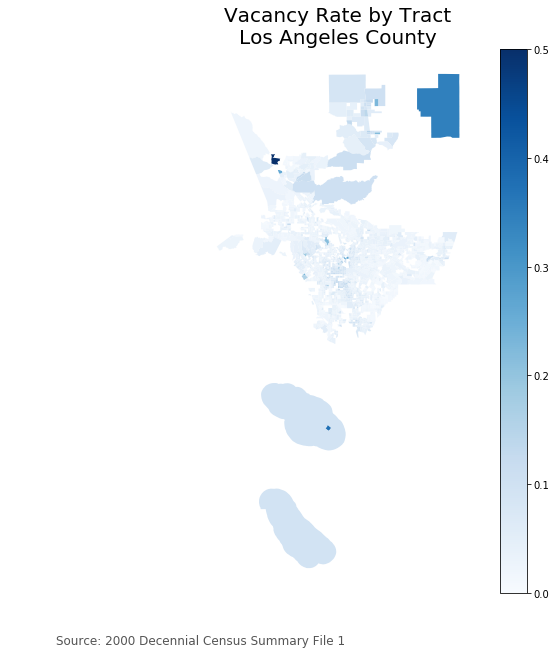

In [5]:
la_data = get_vacant_rates('Los Angeles')
plot_vacant(la_data, 'Los Angeles')

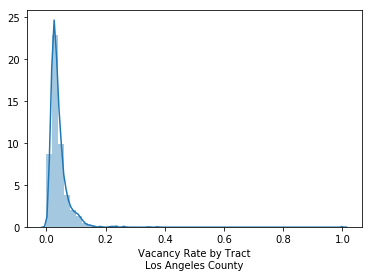

In [6]:
hist_vacant(la_data, 'Los Angeles')

### Vacancy in the western counties

Los Angeles appears to have very low tract-level vacancy rates for all but one of the tracts , located around Santa Clarita. There does not appear to be a spatial pattern in rates of vacancy, at least at the tract-level. The histogram shows the majority of tracts containing no, or close to no, vacancies. 75% of the tracts have less than 5% of vacant houses. Almost all tracts have rates lower than 15%.

Denver's low tract-level vacancy rates are not quite as extreme as Los Angeles. While 75% of the tracts have fewer than 5.6% vacancy, there are a few tracts in the 15%-20% range. While all tracts have relatively low rates, there appear to be three small clusters of slightly higher vacancies. To the east is a cluster of higher-vacancy tracts. These overlap with Lowery Park and the surrounding residential areas. To the south is another group of higher-vacancy tracts, corresponding with the Denver Tech Center office park and Southmoor Park Neighborhood. The highest-vacancy tracts are downtown, where households are more frequently rented apartments.

Harris county (Houston) has markedly higher overall vacancy rates than Los Angeles. 25% of the tracts have vacancy rates over 9%, which is shockingly similar to Manhattan's distribution. The mechanisms behind vacancy in Houston and Manhattan might differ, however. While slowing, Houston was one of the [fastest growing metropolitan areas](https://www.census.gov/prod/cen2010/briefs/c2010br-01.pdf) in the early 2000s. It is possible that some of the vacancies captured by these plots represent new housing stock.

count    123.000000
mean       0.048395
std        0.035862
min        0.008388
25%        0.027034
50%        0.038574
75%        0.056206
max        0.245353
Name: Vacant_Rate, dtype: float64


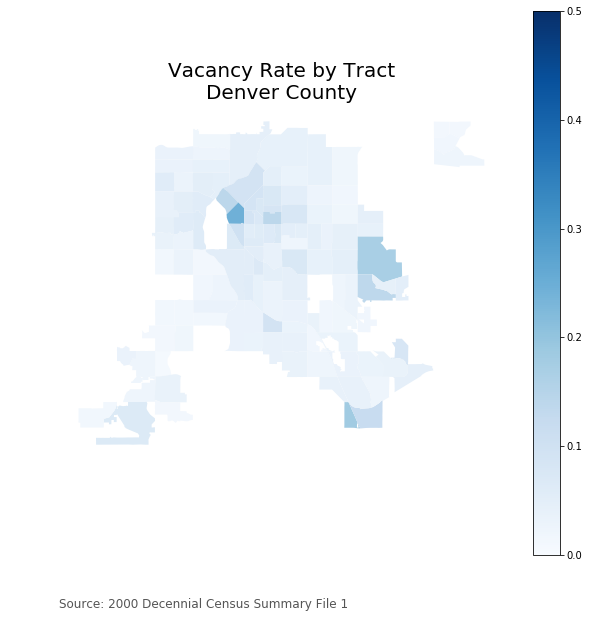

In [7]:
den_data = get_vacant_rates('Denver')
plot_vacant(den_data, 'Denver')

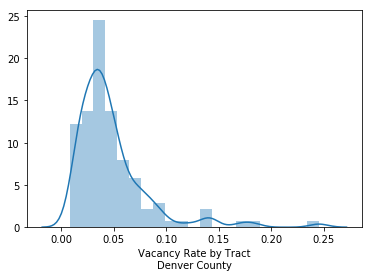

In [8]:
hist_vacant(den_data,'Denver')

count    499.000000
mean       0.073074
std        0.050461
min        0.001866
25%        0.038647
50%        0.060817
75%        0.094239
max        0.423077
Name: Vacant_Rate, dtype: float64


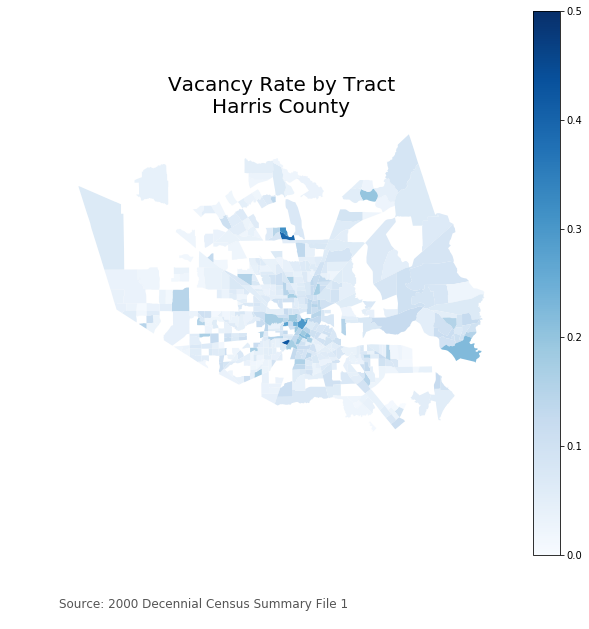

In [9]:
har_data = get_vacant_rates('Harris')
plot_vacant(har_data ,'Harris')

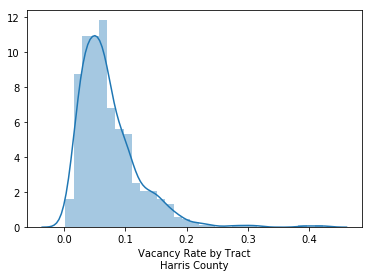

In [10]:
hist_vacant(har_data ,'Harris')

count    988.000000
mean       0.061477
std        0.055353
min        0.002299
25%        0.025255
50%        0.043188
75%        0.081078
max        0.566738
Name: Vacant_Rate, dtype: float64


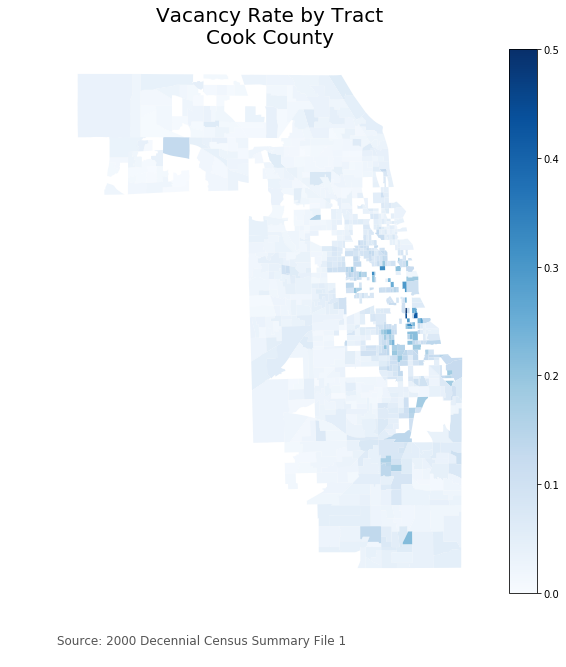

In [11]:
cook_data = get_vacant_rates('Cook')
plot_vacant(cook_data, 'Cook')

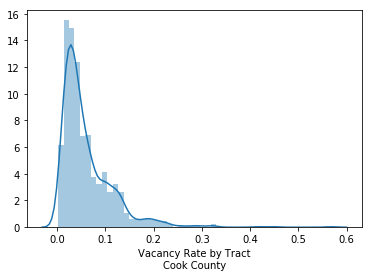

In [12]:
hist_vacant(cook_data, 'Cook')

### Vacancy in Chicago

The tract-level vacancy rates in Cook County (Chicago) are higher on average than the three western counties. The histogram shows a much heavier right tail than in the previous three plots. Several of the higher-vacancy tracts are concentrated downtown, with almost no higher-vacancy tracts further from the urban core. This is predictable, given areas of higher rentership and turnover. Overall vacancy rates are on par with the non-Manhattan New York boroughs.

### Vacancy in New York City

New York county (Manhattan) has a distribution somewhat similar to Chicago's. The mean tract-level vacancy rates are higher than those in the western counties. Additionally, the right tail of the histogram is heavier. In the western counties, only extreme outliers have rates above about 20%. Here, however, roughly 25% of the tracts do.

This is not surprising considering the high renter rate and associated turnover in Manhattan. Unlike Denver and Los Angeles, New York county is entirely urban core. There are no outlying suburban or rural areas, which are much more frequently characterized by home-ownership and low turnover of property.

The other three boroughs studied have mean vacancy rates more similar to Houston's, with an extremely low vacancy rate in Queens. Two entirely-vacant tracts stand out in Queens: one corresponding with rail yard near Long Island City in the eastern part of the county, and one corresponding with Fort Totten Park in the north. Neither of these tracts are populated, but likely still have addressable buildings which count as vacancies. The rest of higher-vacancy tracts are clustered in the Rockaways (the peninsula in the south of the county), again an area with large tracts of park and comparatively low residential density.

Kings county (Brooklyn) had an average tract-level vacancy rate lower than Manhattan, but higher than Denver and Los Angeles. There are fewer zero-vacancy tracts than the other counties. Higher-vacancy tracts to appear clustered, however, in the northern part of the county. This roughly corresponds with Williamsburg and Bedford-Stuyvesant. This areas might be experiencing similar turnover patterns as parts of Manhattan.

The Bronx also has a noticeably high-vacancy tract. This corresponds with a large section of park containing the Bronx Zoo and the New York Botanical Gardens, rather than residential area. The rest of the county's vacancies appear evenly dispersed at the tract-level. 25% of these tracts have vacancy rates over 7%. As in Brooklyn, very few tracts have zero vacancy.

count    267.000000
mean       0.085960
std        0.082531
min        0.000000
25%        0.041744
50%        0.062641
75%        0.092899
max        0.555556
Name: Vacant_Rate, dtype: float64


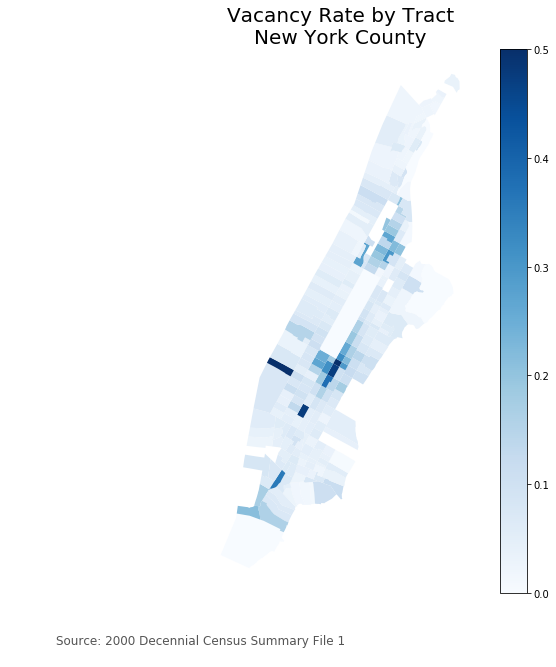

In [13]:
ny_data = get_vacant_rates('New York')
plot_vacant(ny_data, 'New York')

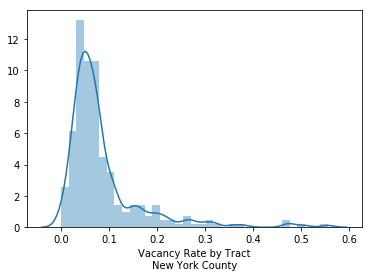

In [14]:
hist_vacant(ny_data, 'New York')

count    699.000000
mean       0.056636
std        0.036293
min        0.000000
25%        0.032594
50%        0.046389
75%        0.068210
max        0.268293
Name: Vacant_Rate, dtype: float64


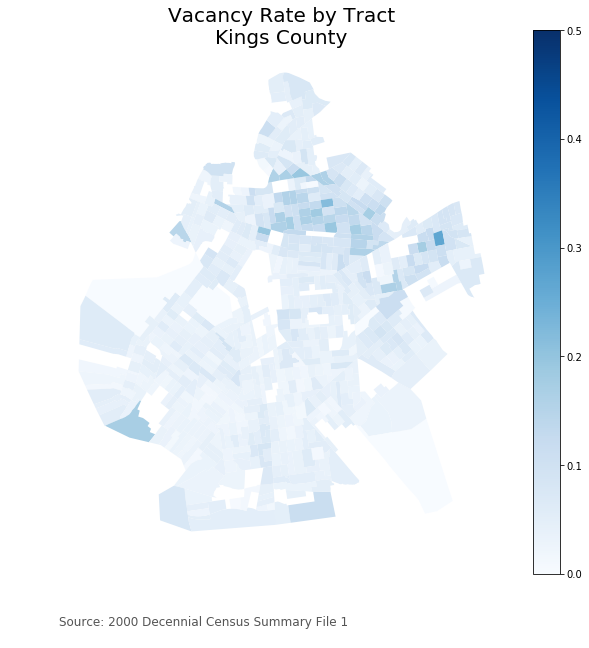

In [15]:
kings_data = get_vacant_rates('Kings')
plot_vacant(kings_data, 'Kings')

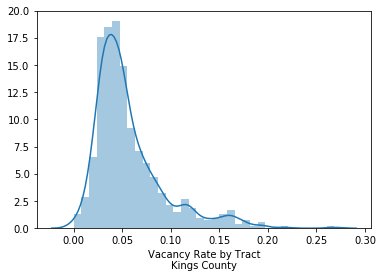

In [16]:
hist_vacant(kings_data, 'Kings')

In [ ]:
queens_data = get_vacant_rates('Queens')
plot_vacant(queens_data, 'Queens')

In [ ]:
hist_vacant(queens_data, 'Queens')

In [ ]:
bronx_data = get_vacant_rates('Bronx')
plot_vacant(bronx_data, 'Bronx')

In [ ]:
hist_vacant(bronx_data, 'Bronx')

For Denver and Los Angeles, these maps support the low- and no-vacancy hypothesis. Areas of extremely low or no vacancy are more likely to have blocks similar to the scenario presented in block 3. Harris County’s results are less straightforward. The tract-level maps do not do much to differentiate Harris from Manhattan. Understanding how vacancy patterns differ between the two counties, and how this might ultimately affect the degree of sub-block clustering, would require higher resolution data of where these vacancies are occurring as well as contextual data (such as new structures and growth rates) to fully understand why.

### Other clues: zero-vacancy blocks

How do block-level rates of homeownership vary using the restricted data? The block-level vacancy rates for each county, generated using point-level data, mirror the tract-level histograms fairly closely. The western three counties have many more blocks with zero vacancies than Chicago and New York. This means that fewer blocks actually change for each run of shuffling households. The only way that street-level rates of vacancy can change by moving residents is if some homes are vacant to begin with. This would mean that of all of the 100 iterations, the county-wide averages would be more similar to each other than in counties with fewer zero-vacancy blocks.

## Conclusions


This notebook highlights four of the 144 hypothesis tests I performed -- the ones where there is not evidence of significant street-level clustering within blocks. While understanding why these cases occurred is important, it is worth reiterating the impact of the other 140 variables.

With the exceptions of vacancy rates and females living with roommates in western counties, the results for all eight counties are remarkably consistent across variables and between each other. I chose these counties to represent cities in different regions of the United States. It is worth noting, however, that my results are insufficient to derive general conclusions about demographic organization in *all* urban areas. They do, however, make a strong case for further exploration of the role of streets in predicting the spatial distribution of socioeconomic variables across the United States.

The propensity of urban residents to sort along streets has crucial implications for the demographic data released by our Federal statistical infrastructure. As is, block-aggregated demographic data available from the Decennial Census and the American Community Survey paint a somewhat erroneous picture of the social landscape. Spatially aggregated census data is implicitly used to infer characteristics about the households, families, and individuals within its borders (even when it shouldn't be). Pretending as if all individuals within a block have the block-average level of income, for example, ignores potentially important within-region variation. The spatial component of this fallacy is more subtle. Even if we understand that a middle-income block might comprise individuals of high and low incomes — resulting in an average that does not match the income level of any of the individual residents — we have no way of inferring where each group of residents lives within the block. As the smallest unit of aggregation available to the public, block data implies that it captures relevant spatial variation in demographic variables. The variation within blocks, this suggests, should be scattered randomly.

This image of spatial randomness within blocks is implicit in the structure of data currently published, and is frequently taken as “true enough” by the policy analysts and social scientists using the data. As my results suggests, within-block spatial randomness is the wrong framework for understanding the typical socioeconomic patterns for these eight counties.


### What about vacancy?


Tract and county level vacancy data provide some potential explanations for the lack of sub-block clustering in the three western counties. These data are limited, however. One of my motivations for studying spatial patterns at a scale smaller than the block is that coarser aggregations obscure differences. There is no way of telling how residents organize themselves within blocks. The two sets of data I've used to explore vacancy rates between my eight counties have the same shortcoming -- aggregate measures don't necessarily apply to the individuals within the group.

Thinking back to the example in block 3, however, we know that the vacancy rate of coarser levels of aggregation can impact how much street-level clustering is possible to observe. Overall, this notebook suggests that the lack of street-level clustering of vacancies in Los Angeles and Denver are at least partly related to low overall vacancy rates. This does not hold, however, for Harris county, where vacancy rates are high.

Future work should look more closely at cases like vacancies in Houston. Why does street-level clustering happen in the first place? What conditions cause it not to happen? Can these conditions help us predict where block-level aggregations are good enough, and where they fail to capture demographic patterns?

For now, these results seem like a great motivation for exploring the importance of streets. We have evidence that at least in some cases, we can do better than blocks.